# Synaptic Plasticity in rate networks

In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch as linepatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from urllib.request import urlopen
from PIL import Image

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")


# This notebook

First you can remind yourself of the different possible plasticity rules in rate based networks.

Then we look at these plasticity rules in action.

### Overview of the different plasticity rules

\begin{align}
ρ =& \; \text{presynaptic rate} \\
v =& \; \text{postsynaptic rate}
\end{align}

Simple Hebbian rule:
\begin{equation}
    \tau \dot{w} = \; v ρ
\end{equation}

If we want to do some analysis on the weight evolution, the simple hebbian rule becomes the correlation based rule:
\begin{equation}
    \tau \dot{w} = \; C w \\
    C = ⟨ \rho \rho^{T} ⟩
\end{equation}


Threshold Hebbian rules:
\begin{align}
    \tau \dot{w} =& \; v (ρ - \theta) \\
    \tau \dot{w} =& \; (v - \theta) ρ \\
    \tau \dot{w} =& \; (v - \theta) (ρ - \theta)
\end{align}

The threshold Hebbian rule becomes the covariance based rule (threshold in pre and post, where we select the threshold to be $ ⟨v⟩$ or $ ⟨ρ⟩$):
\begin{equation}
    \tau \dot{w} = \; Q w \\
    Q = ⟨ (\nu - ⟨\nu⟩) (\rho - ⟨\rho⟩)^{T}⟩
\end{equation}

Hebbian rule with Subtractive normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}n}n
\end{equation}

Hebbian rule with Mulitplicative normalization:
\begin{equation}
    \tau \dot{w} = \; Cw - \frac{n^{T}Cw}{n^{T}w}w
\end{equation}


BCM rule:
\begin{align}
    \tau \dot{w} =& \; v(v-θ ) ρ \\
    \tau_{\theta} \dot{\theta}  =& - θ + \frac{\bar{v}^{2}}{\rho}
\end{align}

In [2]:
def evolve_post(r_pre, r_post, w, dt, tau=20):

    dr_post = dt*(-r_post + np.sum(r_pre*w))/tau

    return r_post+dr_post

In [3]:
def hebbian(r0, r1, tau, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None], r0[None,:])
    return dw, 0

def hebbian_threshold_pre(r0, r1, theta, tau, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None], r0[None,:] - theta)

    return dw, 0

def hebbian_threshold_post(r0, r1, theta, tau, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None] - theta, r0[None,:])

    return dw, 0


def hebbian_subtractive_normalization(r0, r1, tau, dt=0.5, **params):

    dw1 = np.dot(r1[:,None], r0[None,:])   # simple Hebbian term
    dw2 = np.sum(dw1)/np.size(dw1)        # subtractive normalization term
    dw = (dt/tau) * (dw1 - dw2)

    return dw, 0

def hebbian_multiplicative_norm(r0, r1, w, tau, dt=0.5, **params):

    dw1 = np.dot(r1[:,None], r0[None,:])      # simple Hebbian term
    dw2 = (np.sum(dw1)/np.sum(w)) * w       # multiplicative normalization term
    dw = (dt/tau) * (dw1 - dw2)
    return dw, 0

def bcm(r0, r1, theta, tau, tau_theta, r_target, dt=0.5, **params):

    dw = (dt/tau) * np.dot(r1[:,None]*(r1[:,None]-theta), r0[None,:])
    dtheta = (dt/tau_theta) * (-theta + r1[:,None]*r1[:,None]/r_target)

    return dw, dtheta[0,0]

all_plasticity_functions = [
    ('Hebbian',hebbian),
    ('Hebbian Threshold Pre',hebbian_threshold_pre),
    ('Hebbian Threshold Post',hebbian_threshold_post),
    ('Hebbian Subtractive Normalization',hebbian_subtractive_normalization),
    ('Hebbian Multiplicative Norm',hebbian_multiplicative_norm),
    ('BCM',bcm)
    ]

In [4]:
# simple setup to understand the plasticity rules

def investigate_plasticity_rules_simple(
    plasticity_rule,
    n_pre = 2,
    upper_bound = 5,
    theta_start = 0,
    tau_theta = 40,
    r_target = 12):

    tau_w = 1000
    dt = 0.1
    time_steps = 4000


    r_pre = np.array([4.,1.,2.,0.5])
    r_pre = r_pre[:n_pre]
    w = np.ones_like(r_pre)
    r_post = np.array([0.])


    all_pre = r_pre[:]
    all_post = r_post[:]
    all_time = [0]
    all_w = np.array([w])

    theta = theta_start
    all_theta = [theta]





    for ii in range(time_steps):

        r_post = evolve_post(r_pre, r_post, w, dt=dt)


        dw, dtheta = plasticity_rule(r0=r_pre, r1 = r_post, theta=theta, w=w, tau=tau_w, tau_theta=tau_theta, r_target=r_target, dt=dt)

        theta += dtheta

        w += dw.flatten()



        w[w<0] = 0
        w[w>upper_bound] = upper_bound




        if ii%15 == 0:
            all_pre = np.vstack([all_pre, r_pre])
            all_post = np.vstack([all_post, r_post])
            all_time.append(ii*dt)
            all_w = np.vstack([all_w,w])
            all_theta.append(theta)


    fig = plt.figure()
    gs = GridSpec(3, 4)

    # Create subplots using the GridSpec
    ax1 = plt.subplot(gs[0, :-1])
    ax2 = plt.subplot(gs[1, :-1], sharex = ax1)
    ax3 = plt.subplot(gs[2, :-1])
    ax_img = plt.subplot(gs[:, 3])


    ax1.plot(all_time,all_post, c='k')
    if plasticity_rule == bcm or plasticity_rule == hebbian_threshold_post:
        ax1.plot(all_time, all_theta, color = 'r', linestyle = '--', linewidth = 0.8, label = 'postsynaptic threshold')
        ax1.legend()
    ax1.set(
        ylabel = 'Postsynaptic\nactivity')
    ax2.plot(all_time,all_w)
    ax2.axhline(y=upper_bound, c='r', label = 'upper bound', linestyle ='--', linewidth=0.8)
    ax2.legend()
    ax2.set(
        ylabel='Weight',
        xlabel = 'Time in ms')

    all_ticks = []
    all_tick_names = []
    for ii, rr in enumerate(r_pre):
        x_pos = 2*ii
        ax3.bar([x_pos], rr)
        all_ticks.append(x_pos)
        all_tick_names.append(f'Presynaptic neuron {ii+1}')
    ax3.set_xticks(all_ticks)
    ax3.set_xticklabels(all_tick_names)
    if plasticity_rule == hebbian_threshold_pre:
        ax3.axhline(theta, color = 'r', linestyle = '--', linewidth = 0.8, label = 'presynaptic threshold')
        ax3.legend()
    ax3.set(
        ylabel = 'Presynaptic\nactivity',
        ylim = [0,5],
        xlim = [-1, 2*(len(r_pre)-1)+1])


    # Read the image data from the URL
    url = f'https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_7/static/pre_to_post_{len(r_pre)}.png'
    with urlopen(url) as f:
        image = Image.open(f)

    # Convert the image data to a NumPy array
    image_array = np.array(image)

    # Plot the image
    ax_img.imshow(image_array)


    ax_img.axis('off')
    plt.tight_layout()


### Task 1

Here you can explore the different plasticity rules and how they act on a simple feedforward network with 1 to 4 presynaptic neurons.

Take your time to explore the different scenarions. If you make an observation for a specific rule or have a question, please share those at the [Chatwall](https://tweedback.de/zkkh). There, you can also vote on other peoples findings or questions.
(Before you post something, please check whether its already there first)

interactive(children=(Dropdown(description='plasticity_rule', options=(('Hebbian', <function hebbian at 0x79aa…

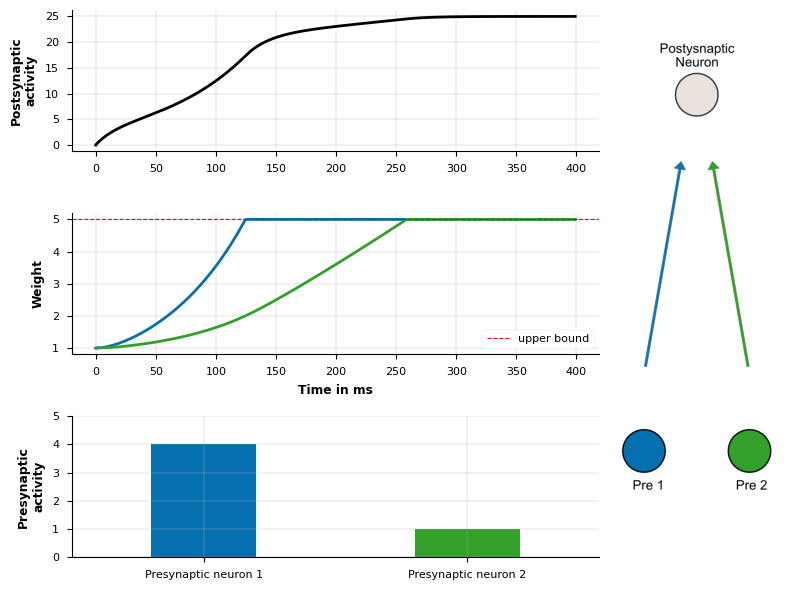

In [5]:
widgets.interactive(investigate_plasticity_rules_simple,
                    plasticity_rule = all_plasticity_functions,
                   upper_bound = (1,10,1),
                   theta_start = (0,10,1),
                   tau_theta = (0.5,4,0.5),
                   r_target = (0,40,2),
                   n_pre = (1,4,1))

Below, we add some helper functions that help styling the complex case

In [6]:
# Helper functions

# manual circular colormap
circular_colors = [
 [0.658308, 0.469939, 0.049413],
 [0.744038, 0.407172, 0.156543],
 [0.810445, 0.335882, 0.263072],
 [0.857457, 0.252094, 0.398416],
 [0.872591, 0.166185, 0.578329],
 [0.836934, 0.161108, 0.76804],
 [0.753424, 0.255361, 0.899179],
 [0.636852, 0.359561, 0.954059],
 [0.49199, 0.449706, 0.941785],
 [0.321912, 0.520685, 0.862792],
 [0.171942, 0.563517, 0.737535],
 [0.096568, 0.584234, 0.611819],
 [0.045551, 0.598018, 0.485098],
 [0.14238, 0.603831, 0.323267],
 [0.368179, 0.578986, 0.125801],
 [0.543825, 0.52618, 0.052752]]


def create_line_for_angle(n_shift, ax):

        x = np.linspace(0,180,17)
        angle = x[n_shift]/360.*2*np.pi
        gain = np.tan(angle)
        line_length = 1
        center = np.array([calc_x_shift(n_shift),0.05])

        a = np.array([np.cos(angle),np.sin(angle)])/60.
        b = np.array([-np.cos(angle),-np.sin(angle)])/60.

        con = linepatch(
            a+center,
            b+center,
            'figure fraction',color=circular_colors[n_shift],linewidth=3)
        ax.add_artist(con)

        return con
def calc_x_shift(n_shift):
    return 0.14+n_shift*0.0512

def create_angle_illustration(ax, n_pre):
    for ii in range(n_pre):
        create_line_for_angle(n_shift=ii,ax=ax)

    ax.set_xticklabels([])


def gaussian(x, mu, sig):
    x = np.copy(x)
    stacked = np.vstack([np.abs(x-mu),np.abs((x-len(x))-mu),np.abs((x+len(x))-mu)])
    arg = np.argmin(stacked,axis=0)

    x[arg == 1] = x[arg == 1]-len(x)
    x[arg == 2] = x[arg == 2]+len(x)

    gaussian = np.exp((-((x - mu)/sig)**2.)/2)
    norm = np.sum(gaussian)

    return gaussian

# Complex input patterns

We now want to look at a more complex case, where
1) we have 16 inputs. We can think of them as neurons that are tuned to specific orientations (i.e. if one orientation is presented, the corresponding neuron will respond the most)

2) The inputs vary now over time, such that the activity of the presynaptic neuron also changes over time.

In [7]:
def run_simulation(
    plasticity_rule,seed=10,
    theta_start = 0.4,
    weight_bias=False,
    gaussian_inputs=True,
    time_step=-1,
    r_target = 8):

    plasticity_rule = plasticity_rule


    np.random.seed(seed)
    n_pre = 16
    upper_bound = 5

    tau_theta = 1

    tau_w = 700
    dt = 0.1
    time_steps = 6000

    r_pre = np.ones(n_pre)
    r_pre = r_pre[:n_pre]
    r_post = np.array([0.])

    X = np.linspace(0,n_pre-1,n_pre)
    mu = np.random.choice(n_pre)
    sig = 2
    if not gaussian_inputs:
        sig = 0.6
    w = np.ones_like(r_pre)*2
    if weight_bias:
        w *= gaussian(x=X, mu=mu,sig=5)

    all_pre = r_pre[:]
    all_post = r_post[:]
    all_time = [0]
    all_w = np.array([w])
    all_angles = [mu]

    theta = theta_start
    all_theta = [theta]
    starting_w = np.copy(w)


    for ii in range(time_steps):

        if np.random.rand() > 0.995:
            mu = np.random.choice(n_pre)


        input_pattern = gaussian(x=X, mu=mu,sig=sig) + 0.0

        r_pre = input_pattern

        r_post = evolve_post(r_pre, r_post, w, dt=dt)

        dw, dtheta = plasticity_rule(r0=r_pre, r1 = r_post, theta=theta, w=w, tau=tau_w, tau_theta=tau_theta, r_target=r_target, dt=dt)

        theta += dtheta

        w += dw.flatten()



        w[w<0] = 0
        w[w>upper_bound] = upper_bound




        if ii%15 == 0:
            all_pre = np.vstack([all_pre, r_pre])
            all_post = np.vstack([all_post, r_post])
            all_time.append(ii*dt)
            all_w = np.vstack([all_w,w])
            all_angles.append(mu)
            all_theta.append(theta)



    fig, (ax1,ax2,ax3) = plt.subplots(3,1, gridspec_kw={'height_ratios': [1, 3,3]})


    ax1.plot(all_time[:time_step],all_post[:time_step])
    if plasticity_rule == bcm or plasticity_rule == hebbian_threshold_post:
        ax1.plot(all_time[:time_step], all_theta[:time_step], color = 'r', linestyle = '--', linewidth = 0.8, label = 'postsynaptic threshold')
        ax1.legend()
    ax1.set(
        xlim = [0,all_time[-1]],
        ylabel = 'Output rate')
    for cc, ww in zip(circular_colors,all_w[:time_step,:].T):
        ax2.plot(all_time[:time_step],ww, c=cc)

    ax2.set(
        xlim = [0,all_time[-1]],
        xlabel = 'Time in ms',
        ylabel = 'Input weights')
    for ii, (pre,cc) in enumerate(zip(all_pre[time_step],circular_colors)):
        ax3.bar([ii],pre, edgecolor = cc, linewidth = 2, facecolor='#f0f0f0', width=0.5)
    ax3.set(
        ylabel = 'Input Rate',
        ylim = [0,np.max(all_pre)*1.1])

    ax3.axvline(all_angles[time_step], linestyle = '--', c='k', label = 'stimulus')
    if plasticity_rule == hebbian_threshold_pre:
        ax3.axhline(all_theta[-1], color = 'r', linestyle = '--', linewidth = 0.8, label = 'presynaptic threshold')
    ax3.legend()
    create_angle_illustration(ax3, n_pre)

    plt.tight_layout()


    fig, ax = plt.subplots(1,figsize =(6,3))
    ax.set(
        title = 'Weight and input distributions',
        xlabel = 'Input Neuron',
        ylabel = 'weight/scaled input'
    )
    ax.bar([ii-0.3 for ii in range(len(w))],starting_w, edgecolor = 'k', linewidth = 0.15, facecolor='#66c2a5', width=0.2, label = 'starting weights')
    ax.bar([ii+0.3 for ii in range(len(w))],w, edgecolor = 'k', linewidth = 0.15, facecolor='#fc8d62', width=0.2, label = 'ending weights')
    mean_input = np.mean(all_pre,axis=0)
    mean_input /= np.max(mean_input)
    mean_input *= np.max(w)

    ax.bar([ii for ii in range(len(w))],mean_input, edgecolor = 'k', linewidth = 0.15, facecolor='#8da0cb', width=0.2, label = 'mean input')
    ax.legend()




### Task 2

I would be great if the postsynaptic neuron could learn the weights, so that it listens only to a couple of neurons and therefore itself would be tuned to a specific orientation (or mixture of orientations) presented. Can you achieve this?

interactive(children=(Dropdown(description='plasticity_rule', options=(('Hebbian', <function hebbian at 0x79aa…

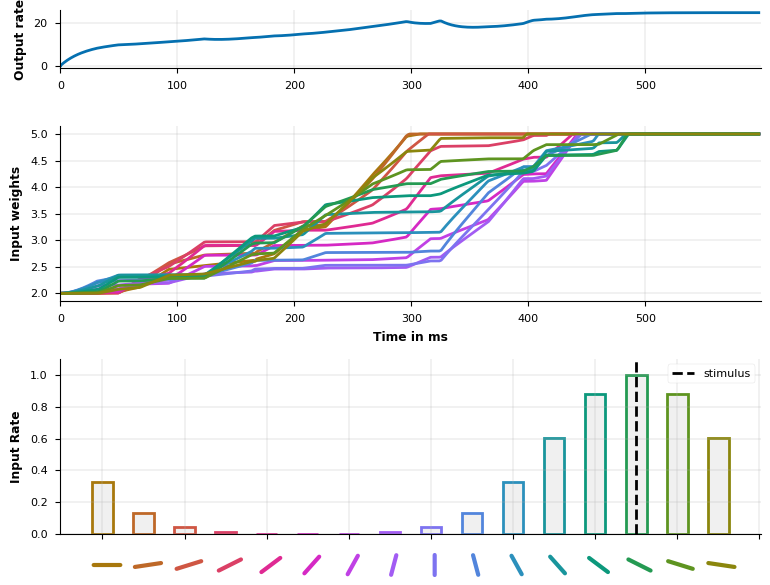

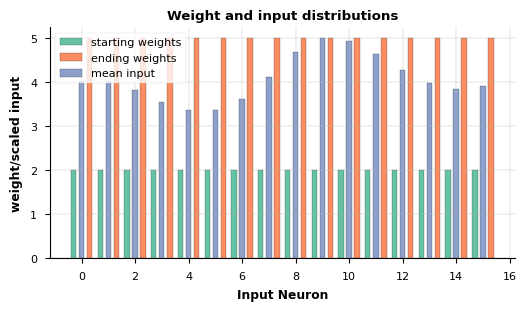

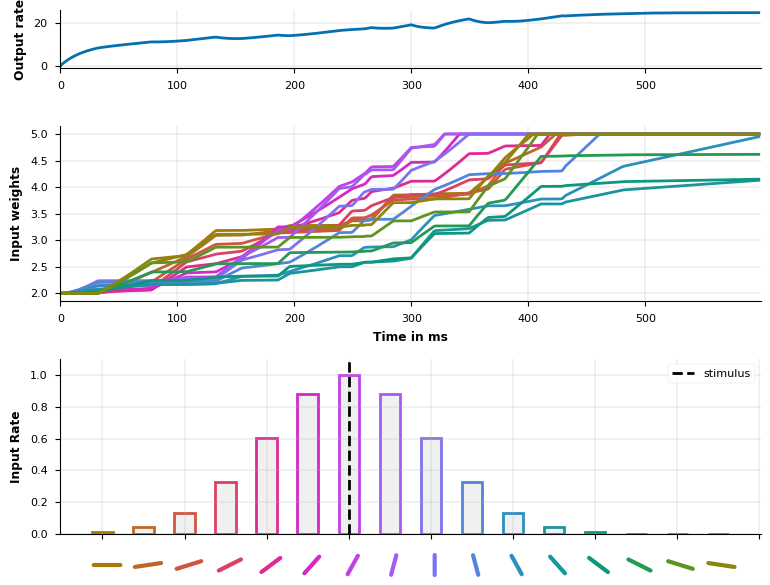

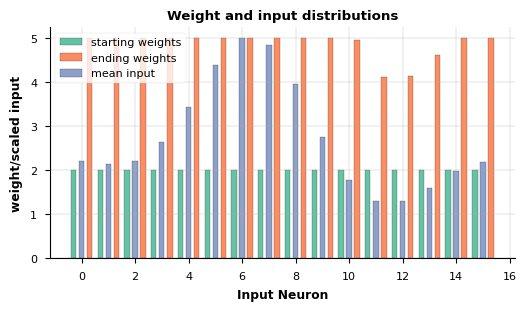

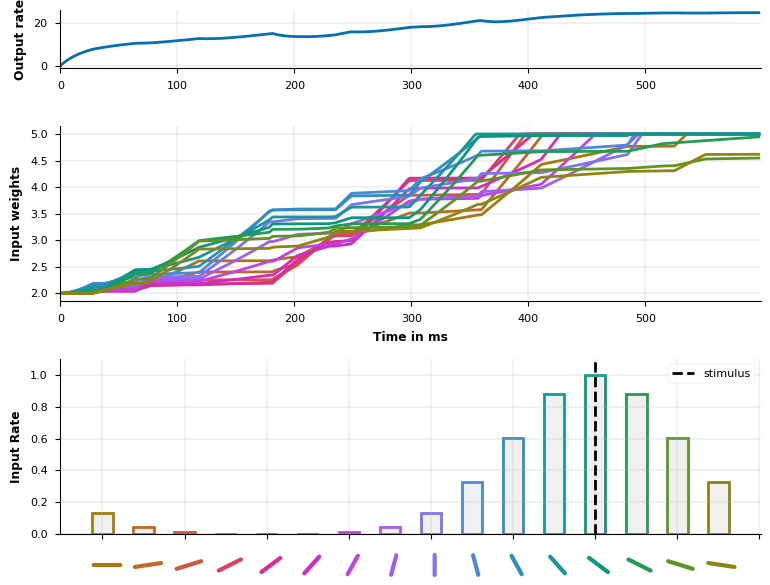

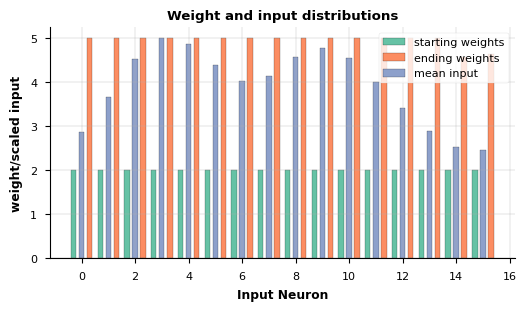

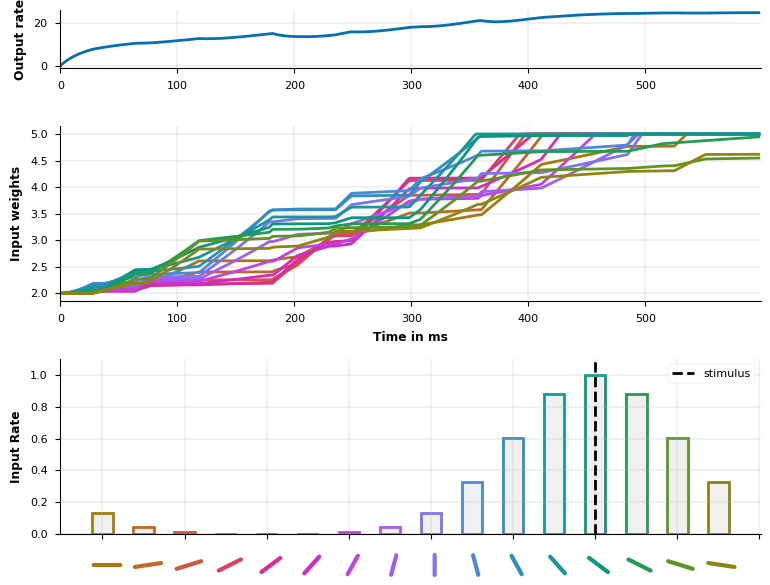

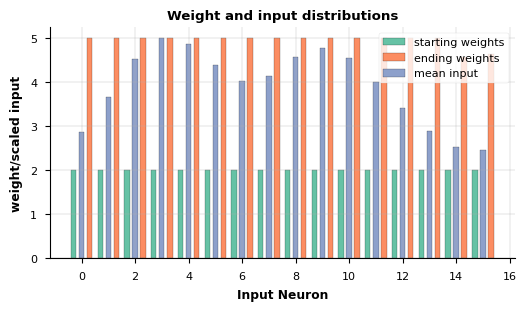

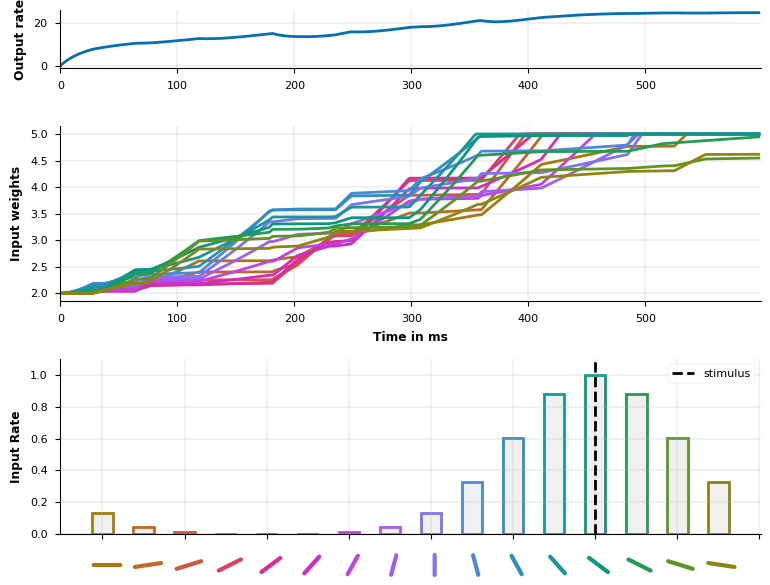

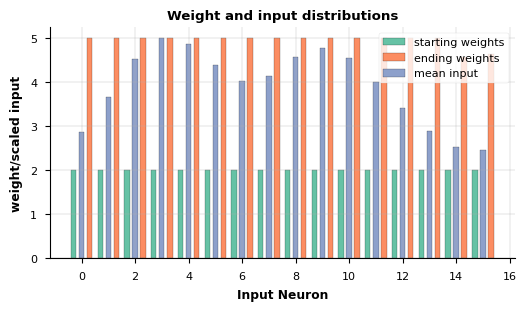

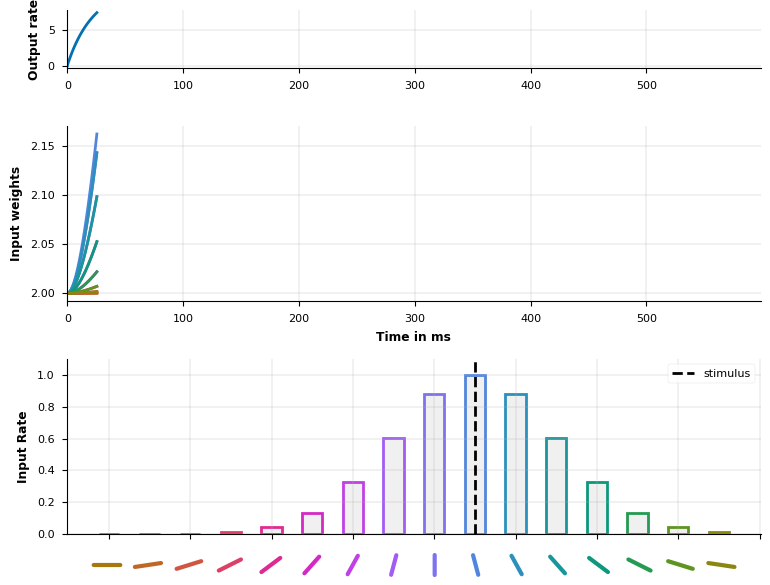

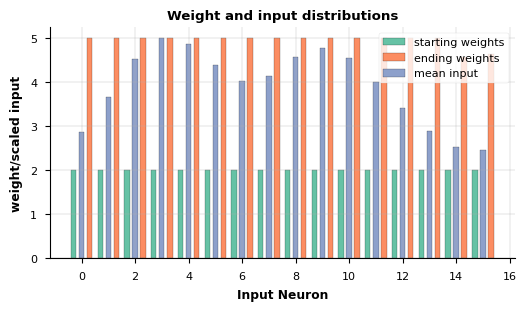

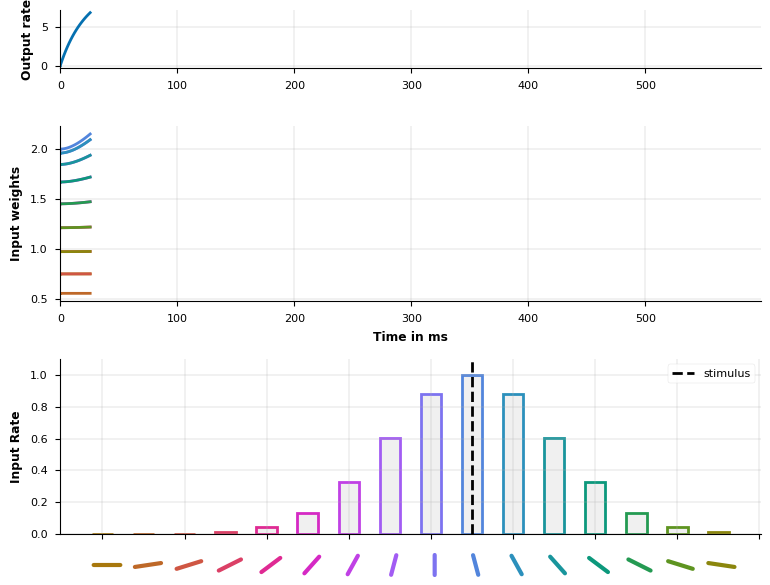

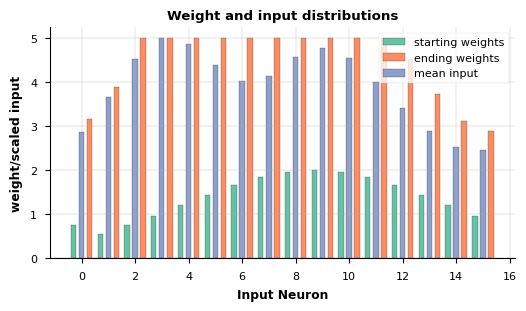

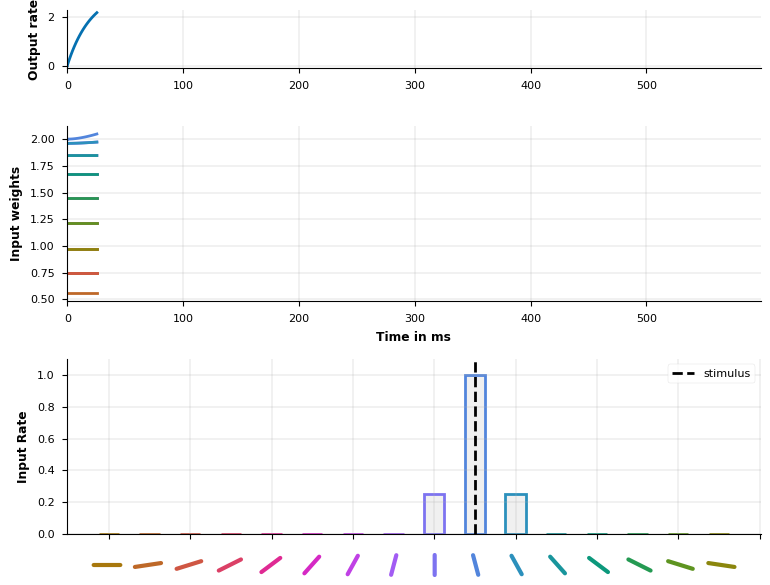

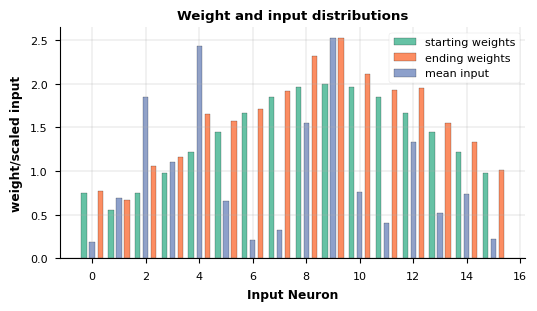

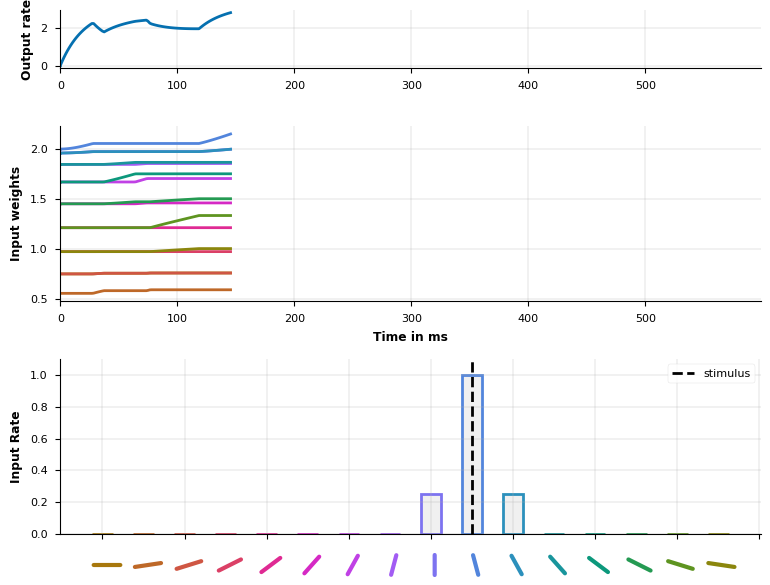

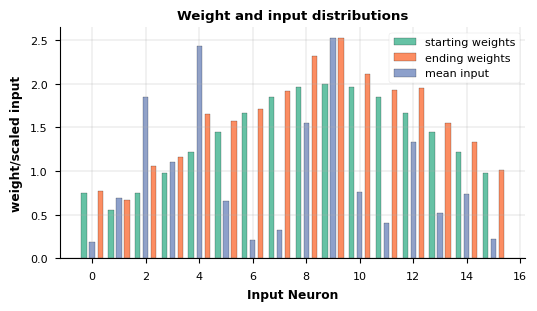

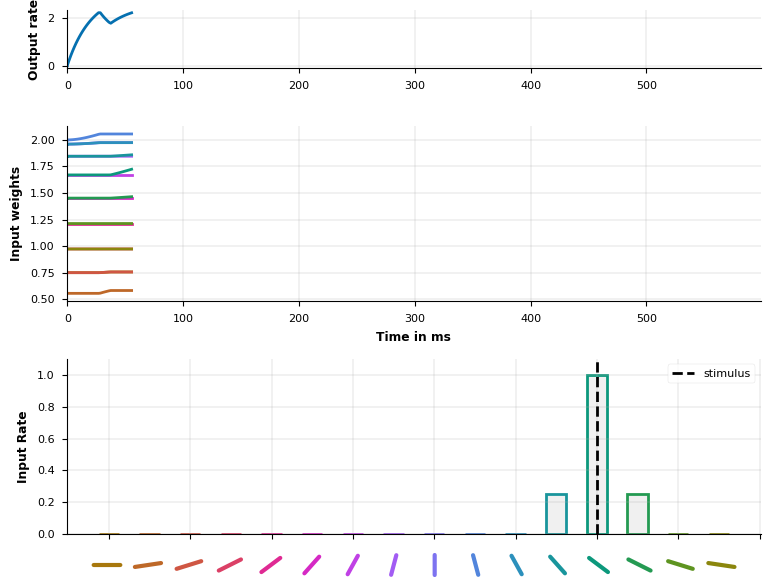

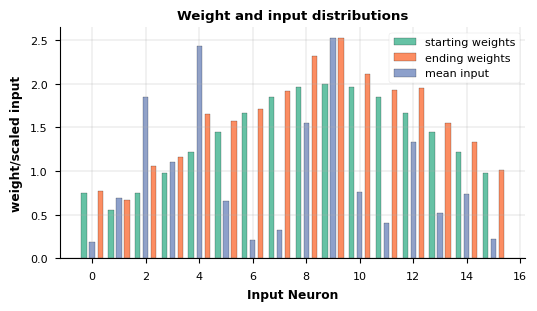

In [8]:
widgets.interactive(
    run_simulation,
    plasticity_rule = all_plasticity_functions,
    theta_start = (0.1,20,0.1),
    time_step = (-1,200,20),
    r_target = (0,10,0.5),)